# 2. Simulators

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----
 [Qiskit Aer](https://github.com/Qiskit/qiskit-aer)에서는 양자회로의 CPU (또는 GPU) 기반 시뮬레이션 backend를 제공합니다.
 대표적으로 Aer에서 제공하는
 Simulation Backend는 다음과 같습니다.

| 이름    | 설명    | 결과    |
|-------------|-------------|-------------|
| qasm_simulator | 이상적이거나 노이즈가 있는 양자 프로세서를 emulation하여 **measurement count** 를 반환합니다. | Counts |
| statevector_simulator | 이상적인 시뮬레이션을 수행하여 **최종 양자상태**를 반환합니다. | Final state (Vector) |
| unitary_simulator | 이상적인 양자회로의 최종 **Unitary Matrix** 를 반환합니다. | Unitary Matrix |

([GPU 기반 Aer](https://github.com/Qiskit/qiskit-aer#installing-gpu-support)는 Linux 운영체제에서만 가능하므로 본 튜토리얼에서는
포함하지 않습니다.)

### 0. 필요한 요소 불러오기

In [13]:
import numpy as np

from qiskit.providers.aer import AerProvider
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
from qiskit.quantum_info import hellinger_fidelity

### 1-1. Ideal QASM Simulation

qasm simulator는 양자 프로세서를 emulation하여 measurement count를 반환합니다.
주어진 실험 횟수(shots)에 대해 결과의 빈도수를 확인할 수 있습니다.

이번 실험에서는 3개의 qubit에 대해 다음과 같은 연산을 수행하는 회로를 구현하였습니다.

![X3](https://github.com/snow0369/qiskit_tutorial_2021_summerschool/raw/master/figures/X3_coupling.png)

- **Binding Parameters** :
다음과 같이 파라미터 Tau를 선언하고, 이를 회로에 적용시킨 뒤 시뮬레이션 단계에서 tau에 적당한 값을 지정할 수 있습니다.

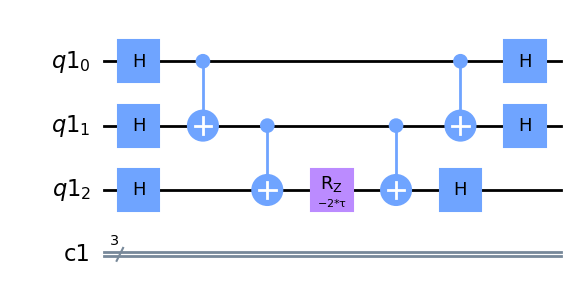

In [14]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

tau = Parameter('τ')

qc.h(qr)
qc.cx(qr[0], qr[1])
qc.cx(qr[1], qr[2])

qc.rz(-2 * tau, qr[2])

qc.cx(qr[1], qr[2])
qc.cx(qr[0], qr[1])
qc.h(qr)
qc.draw('mpl')


**composing circuit** :
다음과 같이 `compose` method를 통해 측정 회로`meas`를 따로 정의하고, 앞서 정의한 회로 `qc`와 병합한 회로 `qasm_qc`를 생성 할 수 있습니다.

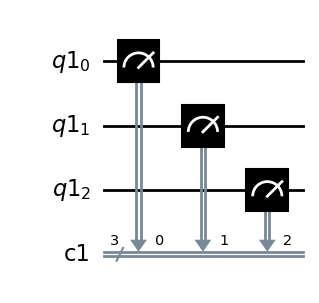

In [15]:
meas = QuantumCircuit(qr, cr)
meas.measure(qr, cr)
meas.draw('mpl')

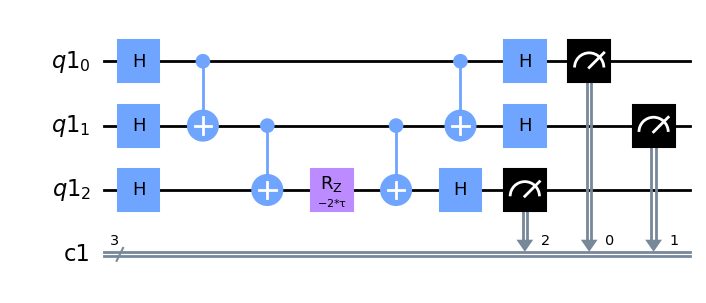

In [16]:
qasm_qc = qc.compose(meas)
qasm_qc.draw('mpl')

이제 tau에 `pi/4`를 대입한 뒤 qasm simulation을 수행합니다.

{'000': 2054, '111': 2042}


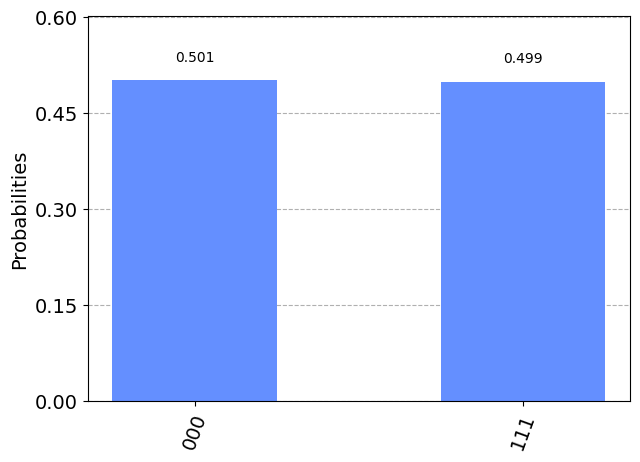

In [17]:
bind_qasm_qc = qasm_qc.bind_parameters({tau: np.pi/4})

qasm_backend = AerProvider().get_backend('qasm_simulator')
job_qasm = qasm_backend.run(bind_qasm_qc, shots=4096)
counts_qasm = job_qasm.result().get_counts()

print(counts_qasm)
plot_histogram(counts_qasm)

### 1-2. Noisy QASM Simulation

다음으로, QASM Simulation에 depolarization error를 추가하는 간단한 예시를 살펴보겠습니다.

**Depolarization Error**

$ E(ρ) = (1 - λ) ρ + λ \text{Tr}[ρ] \frac{I}{2^n} $
* If λ = 0 this is the identity channel. E(ρ) = ρ
* If λ = 1 this is a completely depolarizing channel. E(ρ) = I / 2 <sup> n </sup>
* If λ = 4^n / (4^n - 1) this is a uniform Pauli error channel:

    $E(ρ) = \sum_j P_j ρ P_j / (4^n - 1) \text{ for all } P_j \neq I.$

In [18]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, num_qubits=1)
error_2 = noise.depolarizing_error(prob_2, num_qubits=2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

생성한 노이즈모델과 함께 qasm simulation을 수행합니다.

{'000': 2015, '111': 1974, '100': 29, '010': 14, '011': 33, '001': 14, '101': 13, '110': 4}


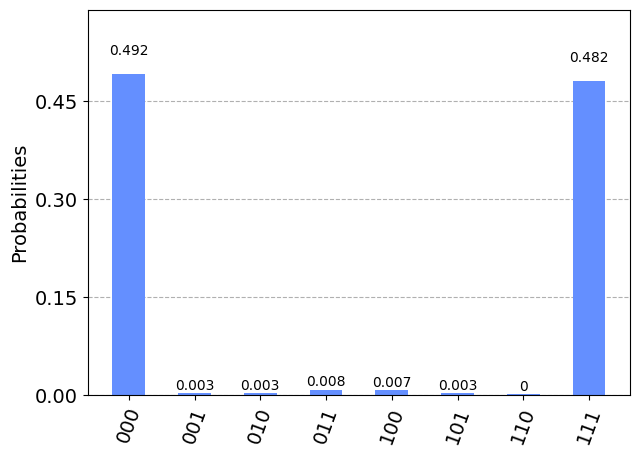

In [19]:
job_qasm_noisy = qasm_backend.run(bind_qasm_qc, shots=4096, noise_model=noise_model)
counts_qasm_noisy = job_qasm_noisy.result().get_counts()
print(counts_qasm_noisy)
plot_histogram(counts_qasm_noisy)

Depolarization noise model을 적용하였을때 Ideal한 case에서 관측되지 않는 결과들과 함께 오차가 발생했음을 확인할 수 있습니다.

Ideal case와 비교하기 위해 fidelity를 계산합니다.

![hellinger](https://github.com/snow0369/qiskit_tutorial_2021_summerschool/raw/master/figures/hellinger.png)

In [20]:
print(hellinger_fidelity(counts_qasm, counts_qasm_noisy))

0.9738638048244478


### 2. Statevector Simulation

다음으로, 최종 양자상태를 확인할 수 있는 statevector simulation을 수행합니다.

* statevector simulation을 수행하는 회로에는 측정 gate를 배제한 다음 회로를 사용합니다.

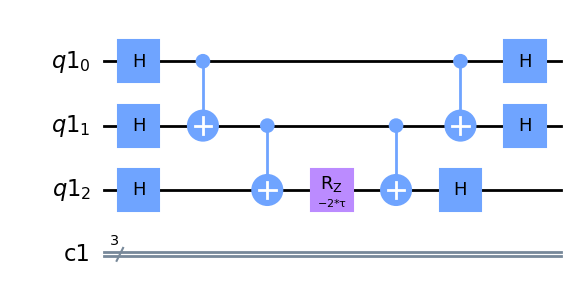

In [21]:
qc.draw('mpl')

In [22]:
bind_qc = qc.bind_parameters({tau: np.pi/4})
sv_backend = AerProvider().get_backend('statevector_simulator')
job_sv = sv_backend.run(bind_qc)
final_sv = job_sv.result().get_statevector()

np.set_printoptions(suppress=True)
print(final_sv)

[ 0.70710678-0.j         -0.        +0.j         -0.        +0.j
 -0.        +0.j         -0.        +0.j         -0.        -0.j
 -0.        -0.j          0.        +0.70710678j]


양자상태가 numpy vector 형태로 주어진 것을 확인할 수 있습니다.

### 2. Statevector Simulation

다음으로, 회로의 unitary 행렬을 확인할 수 있는 unitary simulation을 수행합니다.

* unitary simulation을 수행하는 회로에는 측정 gate를 배제한 회로를 사용합니다.


In [23]:
unitary_backend = AerProvider().get_backend('unitary_simulator')
job_unitary = unitary_backend.run(bind_qc)
unitary = job_unitary.result().get_unitary()
print(unitary)

[[ 0.70710678-0.j          0.        +0.j         -0.        +0.j
  -0.        +0.j         -0.        +0.j         -0.        -0.j
  -0.        +0.j          0.        +0.70710678j]
 [-0.        +0.j          0.70710678-0.j         -0.        +0.j
  -0.        +0.j         -0.        -0.j         -0.        +0.j
   0.        +0.70710678j -0.        -0.j        ]
 [-0.        +0.j         -0.        +0.j          0.70710678-0.j
   0.        +0.j         -0.        +0.j          0.        +0.70710678j
  -0.        +0.j         -0.        -0.j        ]
 [-0.        +0.j         -0.        +0.j          0.        +0.j
   0.70710678-0.j          0.        +0.70710678j -0.        +0.j
  -0.        -0.j          0.        +0.j        ]
 [-0.        +0.j         -0.        -0.j         -0.        +0.j
   0.        +0.70710678j  0.70710678-0.j          0.        +0.j
  -0.        +0.j         -0.        +0.j        ]
 [-0.        -0.j         -0.        +0.j          0.        +0.70710678j
  -

In [24]:
for idx, x in np.ndenumerate(unitary):
    if abs(x) > 1e-7:
        print(f"{idx}, {x.real if abs(x.real) > 1e-7 else 0.0} {' + j'+ str(x.imag) if abs(x.imag) > 1e-7 else 0.0}")

(0, 0), 0.7071067811865477 0.0
(0, 7), 0.0  + j0.7071067811865479
(1, 1), 0.7071067811865477 0.0
(1, 6), 0.0  + j0.7071067811865479
(2, 2), 0.7071067811865477 0.0
(2, 5), 0.0  + j0.7071067811865479
(3, 3), 0.7071067811865477 0.0
(3, 4), 0.0  + j0.7071067811865479
(4, 3), 0.0  + j0.7071067811865479
(4, 4), 0.7071067811865477 0.0
(5, 2), 0.0  + j0.7071067811865479
(5, 5), 0.7071067811865477 0.0
(6, 1), 0.0  + j0.7071067811865479
(6, 6), 0.7071067811865477 0.0
(7, 0), 0.0  + j0.7071067811865479
(7, 7), 0.7071067811865479 0.0
